# **Stock Price Forecasting with XGBoost**
I recently completed a bootcamp course in Data Analytics taught by Alex Chicote and in which we learned how to gain data from
APIs, manipulate it with pandas, create time series ML models, and create visualizations. Here I attempt to put these skills to use by doing some forecasting of stock prices using data from AlphaVantage and the XGBoost model which appeared to be the most successful. I begin with this tutorial: https://www.geeksforgeeks.org/stock-price-prediction-using-machine-learning-in-python/. Assisted by Chat-GPT 4o

## **Importing Required Libraries**
We start by importing the necessary Python libraries. These include:
- `pandas` and `numpy` for data manipulation
- `matplotlib.pyplot` for visualization
- `xgboost` for training our forecasting model
- `sklearn` modules for performance evaluation and model tuning

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## **Loading and Preprocessing Data**
We load the historical stock price data for Tesla (TSLA) from a CSV file. 
- The dataset is assumed to be sourced from AlphaVantage and contains OHLC (Open, High, Low, Close) prices and volume.
- The column names are renamed for easier access.
- We ensure the date index is sorted in ascending order before proceeding.

In [2]:
# Load TSLA data from CSV (assumes 'tsla_data.csv' has dates in the first column)
tsla_df = pd.read_csv('tsla_data.csv', index_col=0, parse_dates=True)

# Rename columns for ease of use
tsla_df.rename(columns={
    '1. open': 'open',
    '2. high': 'high',
    '3. low': 'low',
    '4. close': 'close',
    '5. volume': 'volume'
}, inplace=True)

# Ensure dates are in ascending order (oldest first)
tsla_df = tsla_df.sort_index(ascending=True)
tsla_df.head()

,open,high,low,close,volume
2010-06-29,19.00,25.0000,17.54,23.89,18766300
2010-06-30,25.79,30.4192,23.30,23.83,17187100
2010-07-01,25.00,25.9200,20.27,21.96,8218800
2010-07-02,23.00,23.1000,18.71,19.20,5139800
2010-07-06,20.00,20.0000,15.83,16.11,6866900


## **Naive Forecasting Model**
Before implementing a complex model, we create a simple baseline prediction:
- The naive model assumes that tomorrow's closing price will be the same as today's closing price.
- We compute the Root Mean Squared Error (RMSE) to evaluate how well this naive approach performs.

In [3]:
# Create a naive forecast: the forecast for each day is the previous day's close.
tsla_df['naive_forecast'] = tsla_df['close'].shift(1)

# Drop the first row since it will have a NaN value for the naive forecast
valid_data = tsla_df.dropna()

actual = valid_data['close']
predicted = valid_data['naive_forecast']

rmse = np.sqrt(mean_squared_error(actual, predicted))
print("Naive Model RMSE:", rmse)

# Define test set size
n_test = 734

# Split the data into training and test sets.
train = tsla_df.iloc[:-n_test]
test = tsla_df.iloc[-n_test:]

# For the naive model, the forecast for each test point is the closing price from the previous time step.
# If you want to generate forecasts for the test set, you can shift the test set by 1:
test['naive_forecast'] = test['close'].shift(1)

# Drop the first row of the test set (as it has no forecast)
test = test.dropna()

# Evaluate the naive model on the test set:
rmse_test = np.sqrt(mean_squared_error(test['close'], test['naive_forecast']))
print("Naive Model Test RMSE:", rmse_test)

Naive Model RMSE: 34.528152354567
Naive Model Test RMSE: 27.271038502336268


## **Feature Engineering for XGBoost**
To train an XGBoost model, we need to generate features from the time series data:
- We create lag features (previous day's closing price, etc.).
- The target variable for prediction is the next day's closing price.
- We split the dataset into training and testing sets to evaluate model performance.

In [4]:
def create_lag_features(series, lag=3):
    """
    Create a DataFrame with lag features for a time series.

    Parameters:
      series: pandas Series to create lag features from.
      lag: number of lagged periods to include.

    Returns:
      DataFrame with lag features and the target column.
    """
    df = pd.DataFrame(series.copy())
    # Create lag features
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df[series.name].shift(i)
    # Rename the original column to 'target'
    df.rename(columns={series.name: 'target'}, inplace=True)
    # Drop rows with missing values (resulting from the lag)
    df.dropna(inplace=True)
    return df

# Create lag features for the 'close' column using 3 lags
df_features = create_lag_features(tsla_df['close'], lag=3)

# ------------------------------
# Split Data into Train and Test Sets
# ------------------------------

# Use the last 734 rows as the test set (out of 3677 total rows)
n_test = 734
train = df_features.iloc[:-n_test]
test  = df_features.iloc[-n_test:]

X_train = train.drop('target', axis=1)
y_train = train['target']
X_test  = test.drop('target', axis=1)
y_test  = test['target']

## **Training the XGBoost Model**
We train an XGBoost regression model to predict future stock prices.
- The model is trained using historical stock data.
- We use TimeSeriesSplit for proper validation.
- GridSearchCV is used to tune hyperparameters for optimal performance.

In [5]:
# Use TimeSeriesSplit for cross-validation
cv_split = TimeSeriesSplit(n_splits=3)

# Define a simple parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

# Grid search to find the best parameters
grid_search = GridSearchCV(
    xgb.XGBRegressor(random_state=2024),
    param_grid,
    cv=cv_split
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Train the final XGBoost model using the best parameters
model = xgb.XGBRegressor(**best_params, random_state=2024)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=2024, ...)

## **Model Evaluation and Prediction**
- After training, we generate predictions using the test dataset.
- The RMSE metric is computed to evaluate model performance.
- Finally, we visualize actual vs. predicted prices to assess forecasting accuracy.

Test RMSE: 27.850857666807222


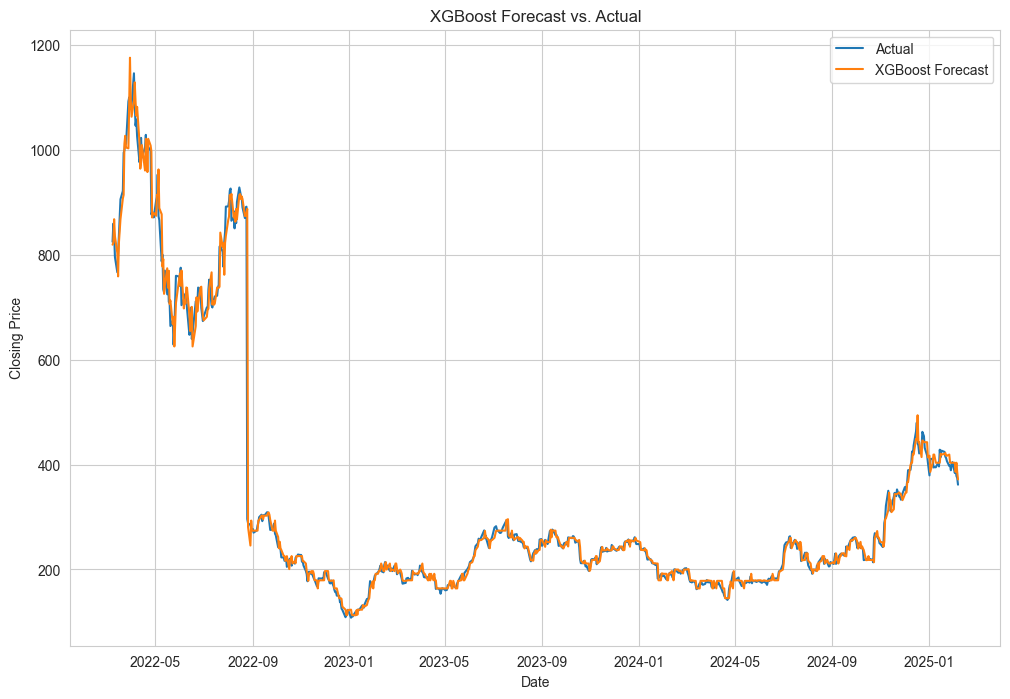

In [6]:
# Predict on the test set and compute RMSE
preds_xg = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_xg))
print('Test RMSE:', rmse)

# (Optional) Plot the forecasts versus actual values
plt.figure(figsize=(12, 8))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, preds_xg, label='XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title("XGBoost Forecast vs. Actual")
plt.legend(loc='best')
plt.show()

## **Feature Engineering for Classification**
In this section, we generate features and prepare the dataset for training an XGBoost classifier.

### **Feature Creation**
- **Price Differences:**
  - `open-close`: Difference between opening and closing prices.
  - `low-high`: Difference between daily low and high prices.
- **Quarter-End Indicator:**
  - `is_quarter_end`: A binary flag (1 if the date falls on a quarter-end, 0 otherwise).
- **Binary Target Variable:**
  - `target`: A classification target where **1** indicates that the next day's closing price is higher than today's, and **0** otherwise.

In [7]:
df = tsla_df.copy()
df['open-close'] = df['open'] - df['close']
df['low-high'] = df['low'] - df['high']
df['is_quarter_end'] = df.index.to_series().dt.is_quarter_end.astype(int)

# Create a binary target: 1 if the next day's close is higher than today's, else 0.
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

# Drop rows with missing values (which arise from shifting and other operations)
df.dropna(inplace=True)


### **Data Preparation**
- **Handling Missing Data:**
  - Rows with missing values (resulting from shifting operations) are removed.
- **Feature Scaling:**
  - StandardScaler is applied to ensure numerical stability.
- **Train-Test Split:**
  - The dataset is split into training and validation sets, using 10% of the data for validation.


In [8]:
# Select the features and the target
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split into training and validation sets (using 10% of data for validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    features_scaled, target, test_size=0.1, random_state=2022
)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)

Training set shape: (3308, 3)
Validation set shape: (368, 3)


## **Training the XGBoost Classifier**
We now train an **XGBoost Classifier** to predict stock price movements.
- The model is trained using the selected features.
- After training, we evaluate the classifier on the validation set.
- Accuracy and a classification report are generated to assess performance.

In [9]:
# Initialize the classifier
clf = xgb.XGBClassifier(random_state=2024)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the validation set
y_pred = clf.predict(X_valid)

# Evaluate performance
accuracy = accuracy_score(y_valid, y_pred)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

Validation Accuracy: 0.5081521739130435

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.50      0.49       173
           1       0.54      0.52      0.53       195

    accuracy                           0.51       368
   macro avg       0.51      0.51      0.51       368
weighted avg       0.51      0.51      0.51       368



## **Conclusion and Model Performance**
- The XGBoost regressor performed worse than the naive model, meaning it did not provide additional forecasting value.
- The XGBoost classifier achieved **50.8% accuracy**, suggesting it provides some predictive power but is not highly reliable.
- Further tuning, additional features, or different modeling techniques may be needed to improve predictive performance.